scale:  1.0000079907767685


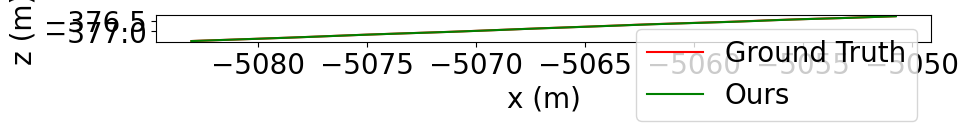

In [ ]:
#对齐位姿
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

def plotPath(seq, poses_gt, poses_result):
    plot_keys = ["Ground Truth", "Ours"]
    plot_color = {"Ground Truth":'r', "Ours":'g'}
    fontsize_ = 20
    plot_num =-1

    poses_dict = {}
    poses_dict["Ground Truth"] = poses_gt
    poses_dict["Ours"] = poses_result

    fig = plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal')

    for key in plot_keys:
        pos_xz = []
        # for pose in poses_dict[key]:
        for frame_idx in range(len(poses_dict[key])):
            pose = poses_dict[key][frame_idx]
            pos_xz.append([pose[0,3],  pose[2,3]])
        pos_xz = np.asarray(pos_xz)
        plt.plot(pos_xz[:,0],  pos_xz[:,1], label = key, color=plot_color[key])

    plt.legend(loc="upper right", prop={'size': fontsize_})
    plt.xticks(fontsize=fontsize_)
    plt.yticks(fontsize=fontsize_)
    plt.xlabel('x (m)', fontsize=fontsize_)
    plt.ylabel('z (m)', fontsize=fontsize_)
    fig.set_size_inches(10, 50)
    # png_title = "sequence_"+(seq)
    # plt.savefig("./" + png_title + ".pdf", bbox_inches='tight', pad_inches=0)

def umeyama_alignment(x, y, with_scale=False):
    """
    Computes the least squares solution parameters of an Sim(m) matrix
    that minimizes the distance between a set of registered points.
    Umeyama, Shinji: Least-squares estimation of transformation parameters
                     between two point patterns. IEEE PAMI, 1991
    :param x: mxn matrix of points, m = dimension, n = nr. of data points
    :param y: mxn matrix of points, m = dimension, n = nr. of data points
    :param with_scale: set to True to align also the scale (default: 1.0 scale)
    :return: r, t, c - rotation matrix, translation vector and scale factor
    """
    if x.shape != y.shape:
        assert False, "x.shape not equal to y.shape"

    # m = dimension, n = nr. of data points
    m, n = x.shape

    # means, eq. 34 and 35
    mean_x = x.mean(axis=1)
    mean_y = y.mean(axis=1)

    # variance, eq. 36
    # "transpose" for column subtraction
    sigma_x = 1.0 / n * (np.linalg.norm(x - mean_x[:, np.newaxis])**2)

    # covariance matrix, eq. 38
    outer_sum = np.zeros((m, m))
    for i in range(n):
        outer_sum += np.outer((y[:, i] - mean_y), (x[:, i] - mean_x))
    cov_xy = np.multiply(1.0 / n, outer_sum)

    # SVD (text betw. eq. 38 and 39)
    u, d, v = np.linalg.svd(cov_xy)

    # S matrix, eq. 43
    s = np.eye(m)
    if np.linalg.det(u) * np.linalg.det(v) < 0.0:
        # Ensure a RHS coordinate system (Kabsch algorithm).
        s[m - 1, m - 1] = -1

    # rotation, eq. 40
    r = u.dot(s).dot(v)

    # scale & translation, eq. 42 and 41
    c = 1 / sigma_x * np.trace(np.diag(d).dot(s)) if with_scale else 1.0
    t = mean_y - np.multiply(c, r.dot(mean_x))

    return r, t, c

def sixD_to_mtx(r):
    b1 = r[..., 0]
    b1 = b1 / torch.norm(b1, dim=-1)[:, None]
    b2 = r[..., 1] - torch.sum(b1 * r[..., 1], dim=-1)[:, None] * b1
    b2 = b2 / torch.norm(b2, dim=-1)[:, None]
    b3 = torch.cross(b1, b2)

    return torch.stack([b1, b2, b3], dim=-1)

def get_cam2world(r_c2w, t_c2w, view_ids=None, starting_id=0):
    if view_ids is not None:
        r_c2w = torch.stack([r_c2w[view_id] for view_id in view_ids], dim=0)
        t_c2w = torch.stack([t_c2w[view_id] for view_id in view_ids], dim=0)
    else:
        r_c2w = torch.stack(list(r_c2w[starting_id:]), dim=0)
        t_c2w = torch.stack(list(t_c2w[starting_id:]), dim=0)
    new_row = torch.tensor([0, 0, 0, 1], dtype=torch.float).view(1, 1, 4).repeat(r_c2w.shape[0], 1, 1)
    return torch.cat((torch.cat([sixD_to_mtx(r_c2w), t_c2w[..., None]], dim = -1), new_row.to(r_c2w.device)), dim=1)

def read_localrf_poses(path=None):
    state_dict = torch.load(path)

    r_list, t_list = [], []
    for key in state_dict["state_dict"]:
        if "r_c2w" in key:
            r_list.append(state_dict["state_dict"][key])
        if "t_c2w" in key:
            t_list.append(state_dict["state_dict"][key])
    pose_mtx = get_cam2world(r_list, t_list)
    return pose_mtx

# pred_path = "data/kitti_mot/training/depth_02/0001/pred_poses.txt"
# gt_path = "data/kitti_mot/training/depth_02/0001/gt_poses_cam2.txt"
# pred_path = "data/waymo_scenes/0017085/depth_0/pred_poses.txt"
gt_path = "data/waymo_scenes/0017085/depth_0/gt_poses_cam0.txt"
learned_poses = np.loadtxt(pred_path).reshape(-1, 4, 4)
gt_poses = np.loadtxt(gt_path).reshape(-1, 4, 4)
plotPath("016", learned_poses, gt_poses)

gt_poses_new, learned_poses_new = [], []
# Pose alignment to first frame
pred_0 = learned_poses[0]
gt_0 = gt_poses[0]
for cnt in range(len(learned_poses)):
    # tmp_learned = np.linalg.inv(pred_0) @ learned_poses[cnt]
    # learned_poses_new.append(tmp_learned)
    learned_poses[cnt] = np.linalg.inv(pred_0) @ learned_poses[cnt]
    
    # tmp = np.linalg.inv(gt_0) @ gt_poses[cnt]
    # gt_poses_new.append(tmp)
    gt_poses[cnt] = np.linalg.inv(gt_0) @ gt_poses[cnt]
    # print("s")

# get XYZ
xyz_gt = []
xyz_result = []
for cnt in range(len(gt_poses)):
    xyz_gt.append([gt_poses[cnt][0, 3], gt_poses[cnt][1, 3], gt_poses[cnt][2, 3]])
    xyz_result.append([learned_poses[cnt][0, 3], learned_poses[cnt][1, 3], learned_poses[cnt][2, 3]])
xyz_gt = np.asarray(xyz_gt).transpose(1, 0)
xyz_result = np.asarray(xyz_result).transpose(1, 0)
r, t, scale = umeyama_alignment(xyz_result, xyz_gt, True)
print("scale: ", scale)
align_transformation = np.eye(4)
align_transformation[:3:, :3] = r
align_transformation[:3, 3] = t

for cnt in range(len(learned_poses)):
    learned_poses[cnt][:3, 3] *= scale
    learned_poses[cnt] = align_transformation @ learned_poses[cnt]

# learned_poses_new = np.asarray(learned_poses_new)
# gt_poses_new = np.asarray(gt_poses_new)

# Plotting
# plotPath("016", test_poses, test_poses)
# np.savetxt("aligned_poses.txt", np.array(learned_poses_new).reshape(-1, 16))